**LEITURA E FORMATAÇÃO DO DATASET**

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
filepath = 'emprestimos.txt'
filenames = []
with open(filepath) as fp:  
   line = fp.readline()
   cnt = 1
   while line:
      filenames.append(line)
      line = fp.readline()
      cnt += 1

semestres = (nome[-6:].rstrip('\n').strip('-') for nome in filenames)
l_empr = [pd.read_csv(name, sep=';') for name in filenames] # lista de dataframes de cada semestre
for df in l_empr:
  df['semestre'] = next(semestres)  # lista de dataframes de cada semestre
  print(df['codigo_barras'].value_counts().head(1))
emprestimo_bruto = pd.concat(l_empr,axis=0) # Concat neles
exemplares_arcevo =  pd.read_csv('http://bit.do/exemplares_arcervo', sep=';')
exemplares_sem_barra = pd.read_csv('http://bit.do/arcevo', sep=';')
exemplares_com_barra = pd.read_csv('http://bit.do/exemplares', sep=';')
exemplares_merge = pd.merge (exemplares_arcevo,exemplares_com_barra, on = 'registro_sistema',how='inner')
emprestimo_bruto['data_emprestimo']= pd.to_datetime(emprestimo_bruto['data_emprestimo'], errors='coerce')
emprestimo_bruto['data_devolucao']= pd.to_datetime(emprestimo_bruto['data_devolucao'], errors='coerce')
emprestimo_bruto['data_renovacao']= pd.to_datetime(emprestimo_bruto['data_devolucao'], errors='coerce')
emprestimo_bruto.dropna(axis=0,subset=['data_devolucao'],inplace=True)
emprestimo_bruto['tempo_pra_devolver'] = emprestimo_bruto['data_devolucao'] -emprestimo_bruto['data_emprestimo']



2006039067    24
Name: codigo_barras, dtype: int64
2011075249    26
Name: codigo_barras, dtype: int64
2010049651    23
Name: codigo_barras, dtype: int64
2012009294    25
Name: codigo_barras, dtype: int64
2010091988    28
Name: codigo_barras, dtype: int64
2009055616    28
Name: codigo_barras, dtype: int64
2015009066    20
Name: codigo_barras, dtype: int64
2009055616    35
Name: codigo_barras, dtype: int64
2015009066    32
Name: codigo_barras, dtype: int64
2014061927    30
Name: codigo_barras, dtype: int64
2015009066    25
Name: codigo_barras, dtype: int64
2009055616    21
Name: codigo_barras, dtype: int64


**INFO SOBRE OS DATA SETS**


In [0]:
#emprestimo_bruto['renovado'] =  emprestimo_bruto['data_renovacao'].isnull()

#emprestimo_bruto['atrasado'] = (emprestimo_bruto['tempo_pra_devolver'] > '15 days' & emprestimo_bruto['renovado'] == False) | (emprestimo_bruto['tempo_pra_devolver'] > '30 days' & emprestimo_bruto['renovado'] ==True)
print('1')
print(emprestimo_bruto.info())
print('2')
print(exemplares_arcevo.info())
print('3')
print(exemplares_sem_barra.info())
print('4')
print(exemplares_com_barra.info())



1
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1428967 entries, 0 to 110325
Data columns (total 10 columns):
id_emprestimo           1428967 non-null int64
codigo_barras           1428967 non-null object
data_renovacao          1428967 non-null datetime64[ns]
data_emprestimo         1428967 non-null datetime64[ns]
data_devolucao          1428967 non-null datetime64[ns]
nome_usuario            1428967 non-null object
id_vinculo_usuario      1428967 non-null int64
tipo_vinculo_usuario    1428967 non-null object
semestre                1428967 non-null object
tempo_pra_devolver      1428967 non-null timedelta64[ns]
dtypes: datetime64[ns](3), int64(2), object(4), timedelta64[ns](1)
memory usage: 119.9+ MB
None
2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209542 entries, 0 to 209541
Data columns (total 12 columns):
registro_sistema    209542 non-null int64
titulo              209531 non-null object
sub_titulo          84913 non-null object
assunto             208563 non-null obj

** FUNÇÃO QUE CONTA O NÚMERO DE EMPRÉSTIMO QUE CADA LIVRO POSSUI E RETORNA UM DF COM O TOP N **

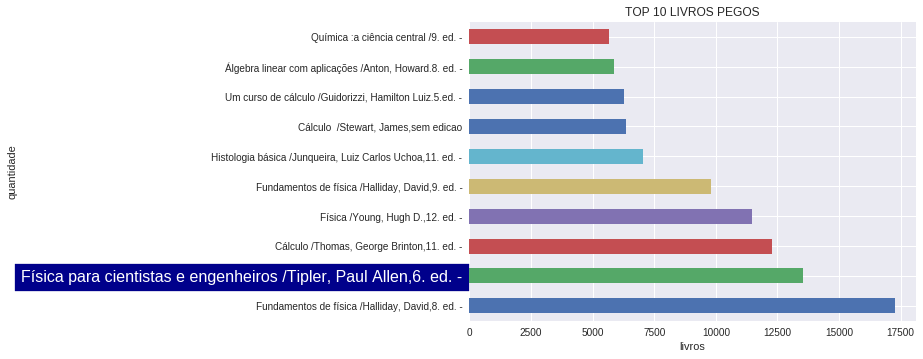

In [0]:
emprestimo = pd.merge(emprestimo_bruto,exemplares_merge, on = 'codigo_barras',how= 'left') # mergem do emprestimo com os exemplares pra vincular os nomes dos livros aos empréstimos
emprestimo.set_index('data_emprestimo',inplace=True)
emprestimo.sort_index(inplace = True,ascending = False)

def top_n_livros (emprestimo_,n):
  top_n_livros_mais_pegos = pd.DataFrame(emprestimo_['registro_sistema'].value_counts().head(n)).reset_index()
  top_n_livros_mais_pegos.rename(columns={'registro_sistema':'qt','index':'registro_sistema'},inplace=True)
  sem_repetir = exemplares_merge.drop_duplicates()
  sem_repetir = sem_repetir.loc[sem_repetir['registro_sistema'].isin(top_n_livros_mais_pegos['registro_sistema'].astype(int)),
                  ['registro_sistema','titulo','sub_titulo','autor','edicao']].drop_duplicates().set_index('registro_sistema')
  top_n_livros_mais_pegos.set_index('registro_sistema',inplace=True)
  top_n_livros_mais_pegos =pd.merge(top_n_livros_mais_pegos,sem_repetir,left_index=True,right_index=True)
  top_n_livros_mais_pegos['sub_titulo'].fillna('',inplace=True)
  top_n_livros_mais_pegos['edicao'].fillna('sem edicao',inplace=True)
  top_n_livros_mais_pegos['autor'].fillna('',inplace=True)  
  top_n_livros_mais_pegos['info']= top_n_livros_mais_pegos['titulo'] + top_n_livros_mais_pegos['sub_titulo']+top_n_livros_mais_pegos['autor'] + top_n_livros_mais_pegos['edicao']
  return top_n_livros_mais_pegos

top_10_livros_mais_pegos = top_n_livros(emprestimo,10)
top_10_livros_mais_pegos.plot(x='info',y='qt',kind='barh',legend=False).set(xlabel = 'livros',ylabel='quantidade',title='TOP 10 LIVROS PEGOS')
l = [t.get_text() == 'Física para cientistas e engenheiros /Tipler, Paul Allen,6. ed. -'  for t in plt.yticks()[1][:]]
if(True in l):
  plt.yticks()[1][l.index(True)].set_backgroundcolor('darkblue')
  plt.yticks()[1][l.index(True)].set_color('white')
  plt.yticks()[1][l.index(True)].set_fontsize(16)
from google.colab import files

plt.savefig('grafico_semestres.png',format = 'png',bbox_inches='tight')

files.download('grafico_semestres.png')

**VERIFICAMOS QUE O LIVRO Física para cientistas e engenheiros POSSUI UM COMPORTAMENTO INTERESSANTE**

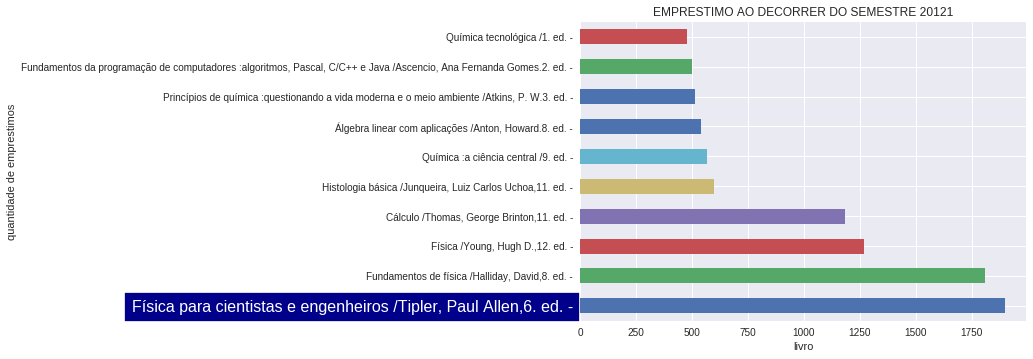

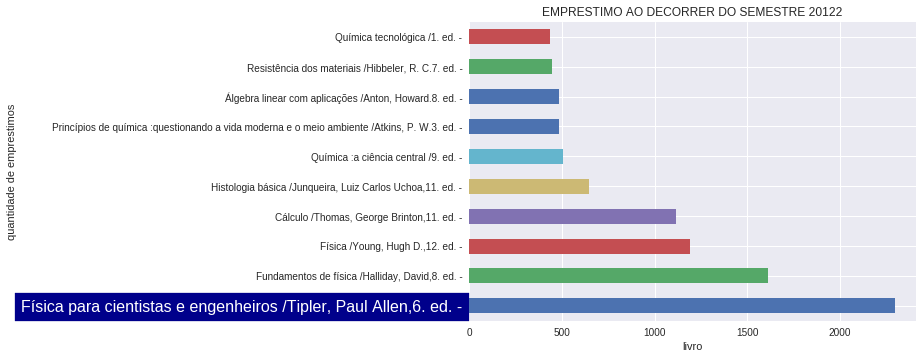

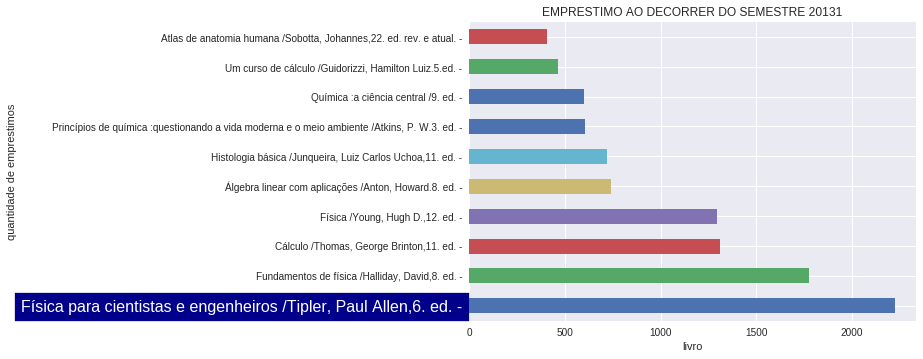

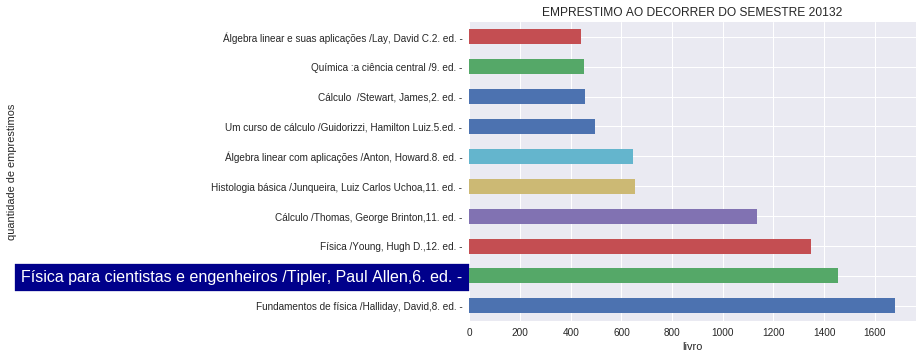

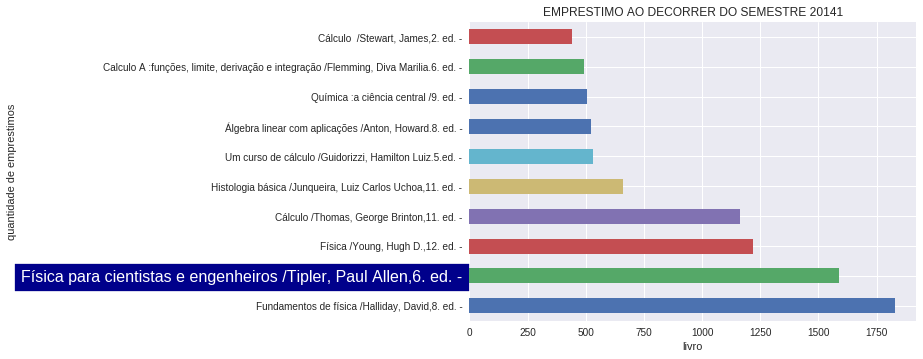

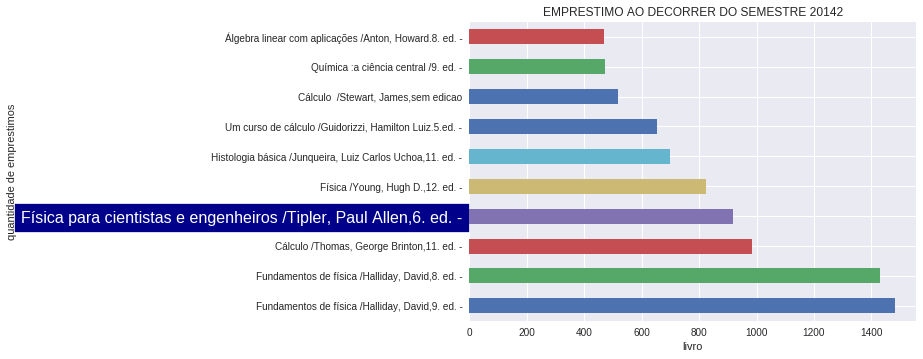

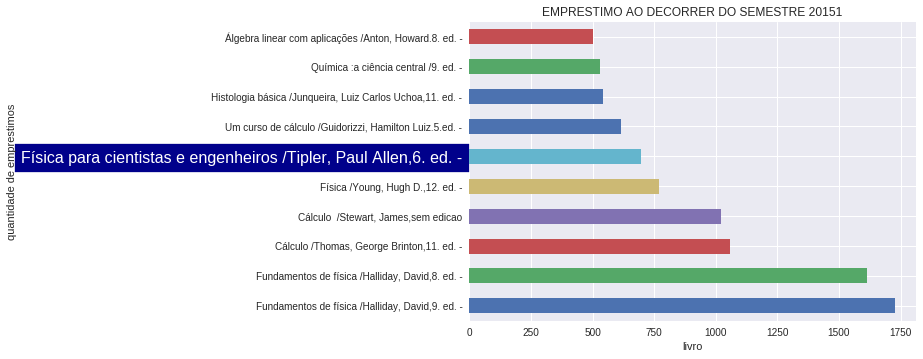

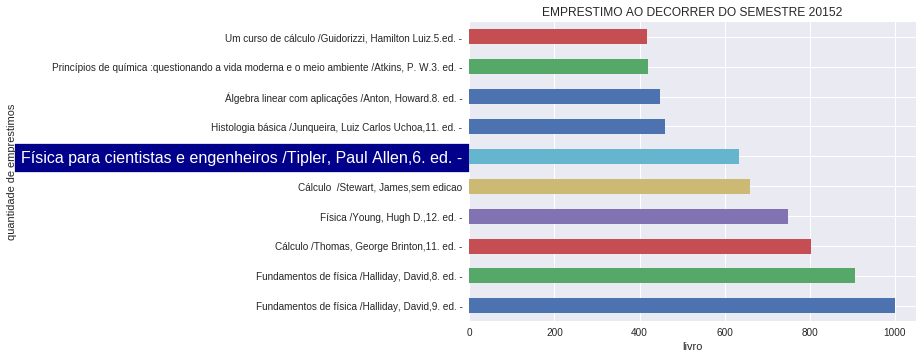

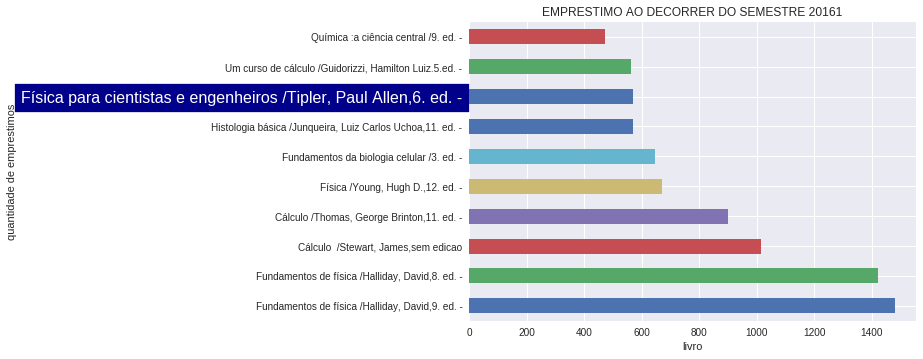

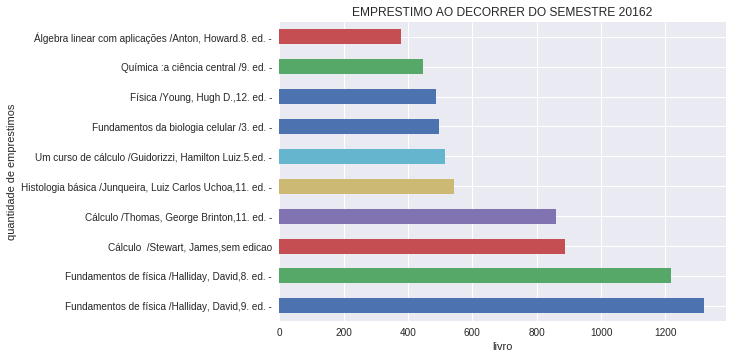

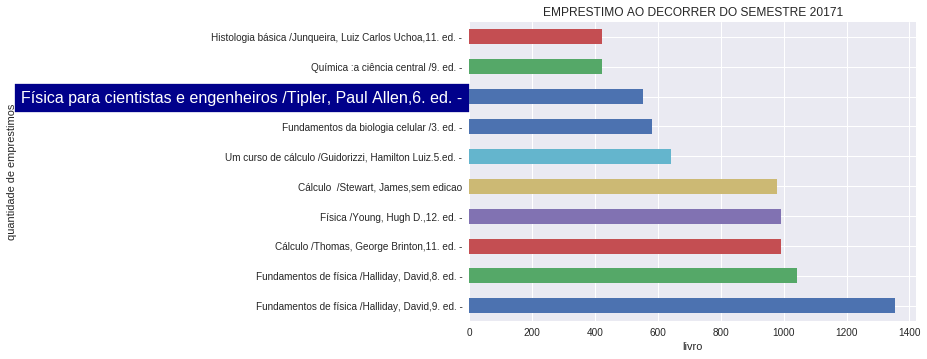

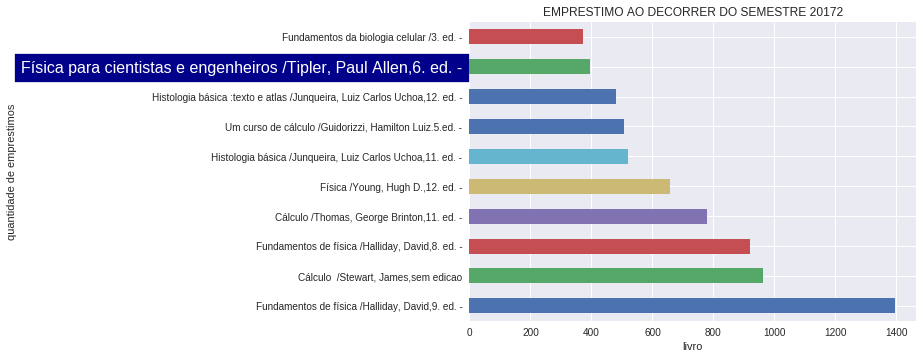

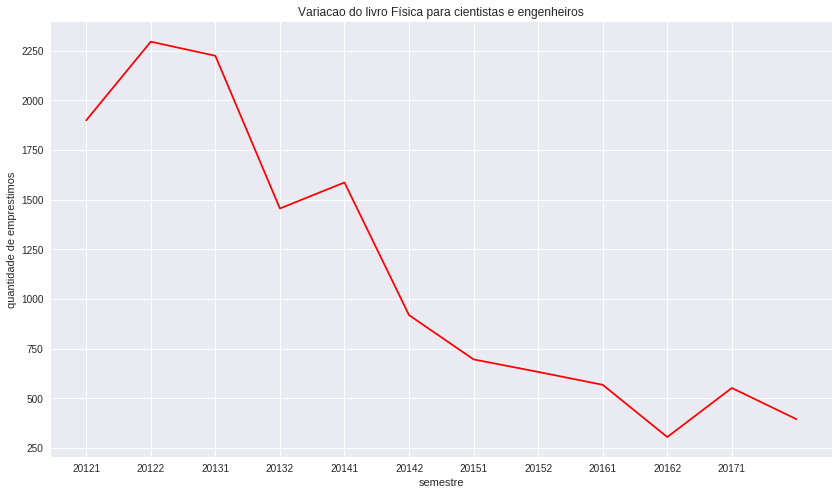

,id_emprestimo,codigo_barras,data_renovacao,data_devolucao,nome_usuario,id_vinculo_usuario,tipo_vinculo_usuario,semestre,tempo_pra_devolver,registro_sistema,...,ano,edicao,editora,isbn,issn,id_exemplar,colecao,biblioteca,status_material,localizacao
data_emprestimo,,,,,,,,,,,,,,,,,,,,,
2017-12-29 18:21:09.060,2580582,2014070441,2018-01-31 18:50:25,2018-01-31 18:50:25,MAGALY ALEXANDRE SANTIAGO,651566,ALUNO DE GRADUAÇÃO,20172,33 days 00:29:15.940000,216228.0,...,2004.,NaN,"Edusc,",8508037872,NaN,1165683.0,Acervo Circulante,Biblioteca Central Zila Mamede,REGULAR,398.47 N778b
2017-12-29 18:18:48.055,2580581,2013093013,2018-01-02 18:22:10,2018-01-02 18:22:10,GABRIEL MIRANDA BRITO,716522,ALUNO DE PÓS-GRADUAÇÃO,20172,4 days 00:03:21.945000,203503.0,...,2013.,NaN,"Ipea,",9788578111663,NaN,1088670.0,Acervo Circulante,Biblioteca Central Zila Mamede,ESPECIAL,331.522.4 D451
2017-12-29 18:18:48.006,2580580,2012054445,2018-01-02 18:22:17,2018-01-02 18:22:17,GABRIEL MIRANDA BRITO,716522,ALUNO DE PÓS-GRADUAÇÃO,20172,4 days 00:03:28.994000,195210.0,...,2012.,NaN,"CRV,",9788580422887 (broch.).,NaN,1061840.0,Acervo Circulante,Biblioteca Central Zila Mamede,ESPECIAL,330.34(7/8) D451
2017-12-29 17:25:25.068,2580579,2015046054,2018-01-30 16:49:20,2018-01-30 16:49:20,THALIA RAFAELLY LIMA DOS SANTOS,744772,ALUNO DE GRADUAÇÃO,20172,31 days 23:23:54.932000,209925.0,...,2008.,34. ed. -,"Ediouro,",8500007958 (broch.).,NaN,1212091.0,Acervo Circulante,Biblioteca Central Zila Mamede,REGULAR,821.111(73)-3 Y19q 34.ed.
2017-12-29 17:17:32.147,2580578,2016038987,2018-01-02 16:18:44,2018-01-02 16:18:44,MARIA LUCIENE URBANO DE BARROS,722855,ALUNO DE PÓS-GRADUAÇÃO,20172,3 days 23:01:11.853000,104704.0,...,2007.,5. ed. -,"Guanabara Koogan,",9788527712576 (enc.),NaN,1255775.0,Acervo Circulante,Biblioteca Central Zila Mamede,ESPECIAL,611 M822a 5.ed.
2017-12-29 17:17:32.104,2580577,2017022347,2018-01-31 14:12:45,2018-01-31 14:12:45,MARIA LUCIENE URBANO DE BARROS,722855,ALUNO DE PÓS-GRADUAÇÃO,20172,32 days 20:55:12.896000,244634.0,...,2014.,6. ed. -,"Elsevier,",9788535276796 (broch.),NaN,1274467.0,Acervo Circulante,Biblioteca Central Zila Mamede,REGULAR,611 N474a 6.ed.
2017-12-29 17:17:32.066,2580576,2014078566,2018-01-02 16:19:10,2018-01-02 16:19:10,MARIA LUCIENE URBANO DE BARROS,722855,ALUNO DE PÓS-GRADUAÇÃO,20172,3 days 23:01:37.934000,217362.0,...,2012.,[1. ed.]. -,"Companhia das Letras,",9788535923827 (broch.).,NaN,1171600.0,Acervo Circulante,Biblioteca Central Zila Mamede,REGULAR,321.7 T639i 1.ed.
2017-12-29 17:17:32.026,2580575,2013089045,2018-01-02 16:19:00,2018-01-02 16:19:00,MARIA LUCIENE URBANO DE BARROS,722855,ALUNO DE PÓS-GRADUAÇÃO,20172,3 days 23:01:27.974000,203414.0,...,2012.,NaN,"EDUFRN,",9788572739184 (broch.),NaN,1088383.0,Publicações da UFRN,Biblioteca Central Zila Mamede,REGULAR,321.7 V854o UFRN
2017-12-29 17:17:31.985,2580574,2008015385,2018-01-02 16:18:52,2018-01-02 16:18:52,MARIA LUCIENE URBANO DE BARROS,722855,ALUNO DE PÓS-GRADUAÇÃO,20172,3 days 23:01:20.015000,101512.0,...,1996.,2. ed. -,"Vozes,",8532616143 : (Broch.),NaN,243388.0,Acervo Circulante,Biblioteca Central Zila Mamede,REGULAR,321.7 T644q 2.ed.


In [0]:
emprestimolist_sem = list()
semestres = (nome[-6:].rstrip('\n').strip('-') for nome in filenames)

for s in semestres:
  emprestimolist_sem.append(emprestimo[emprestimo['semestre'] == s])
top_10_mais_pegos_semestre= list()
for df in emprestimolist_sem:
  top_10_mais_pegos_semestre.append(top_n_livros(df,10))
semestres = (nome[-6:].rstrip('\n').strip('-') for nome in filenames)

for df in top_10_mais_pegos_semestre:
  s = next(semestres)
  df.plot(x='info',y='qt',kind='barh',legend=False).set(xlabel = 'livros',ylabel='quantidade',title='TOP 10 LIVROS PEGOS EM '+ s)
  plt.title('EMPRESTIMO AO DECORRER DO SEMESTRE '+s)
  plt.xlabel('livro')
  plt.ylabel('quantidade de emprestimos')
  #lista_tick_label = [[loc,text] for loc,text in ]
  l = [t.get_text() == 'Física para cientistas e engenheiros /Tipler, Paul Allen,6. ed. -'  for t in plt.yticks()[1][:]]
  if(True in l):
    plt.yticks()[1][l.index(True)].set_backgroundcolor('darkblue')
    plt.yticks()[1][l.index(True)].set_color('white')
    plt.yticks()[1][l.index(True)].set_fontsize(16)
  plt.savefig('barra_semestres'+s+'.png',format = 'png',bbox_inches='tight')
  files.download('barra_semestres'+s+'.png')
  
plt.show()
CONTAGEM_LIVRO_FPEC_POR_SEMESTRE = emprestimo[emprestimo['registro_sistema'] == 169092].groupby('semestre').count().reset_index()
ax =CONTAGEM_LIVRO_FPEC_POR_SEMESTRE.plot(y='id_emprestimo',x='semestre',color='red',legend=False,title='Variacao do livro Física para cientistas e engenheiros',figsize = (14, 8))
ax.set_xticks(range(0,11))
ax.set_xticklabels(CONTAGEM_LIVRO_FPEC_POR_SEMESTRE['semestre'])
ax.set_xlabel('semestre')
ax.set_ylabel('quantidade de emprestimos')
plt.savefig('FPCE.png',bbox_inches='tight')
files.download('FPEC.png')

plt.show()
emprestimo